In [35]:
import numpy as np
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Flatten, Embedding
from keras.layers import LSTM




# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

from textblob import TextBlob
import re, string, unicodedata
import nltk
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer


#For Training Multinomial Naive Bayess
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV


Explains embeddings very well: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

GloVe embeddings: https://nlp.stanford.edu/projects/glove/

# General Notes and Presentation Notes

* After I have a working model, I can concatenate training and test sets because my testing will be with streamed tweets! 
* There is something wrong with the way that I'm preprocessing tweets, or maybe the word embedding files that I'm using does not contain what I expect
* Naive Bayes VS Glove Embeddings w/ LSTM VS Glove Embeddings w/ stacked LSTMs VS Embeddings + CNN VS ELMO
* When we incorporate backend use the following article for preprocessing:
* TensorBoard for callback optimization
* GridSearch for parameter tuning (best dimensions for embeddings, epochs, etc) ---> save best model



* Great for explaining Word EMbeddings:

https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf?gi=a2d3e63ba57a




In [50]:
from nltk.tokenize import sent_tokenize, word_tokenize

original_data = pd.read_csv("sa-emotions/train_data.csv")

original_data.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


## Work with smaller sample of data and split sentences into array of words

In [51]:
# data = original_data[0:50]
data = original_data[0:10000]

data["content"] = data.apply(lambda row: word_tokenize(row['content']), axis=1)

len(data)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


10000

In [96]:
emotions = ['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness','hate', 'love', 'neutral', 'relief', 'sadness', 'surprise', 'worry']
class_dictionary = {}
for emotion in emotions:
    class_dictionary[emotion] = 0

# class_dictionary

In [97]:
for index, row in data.iterrows():
    class_dictionary[row["sentiment"]] += 1

class_dictionary

{'anger': 44,
 'boredom': 69,
 'empty': 194,
 'enthusiasm': 132,
 'fun': 211,
 'happiness': 469,
 'hate': 535,
 'love': 369,
 'neutral': 1857,
 'relief': 227,
 'sadness': 2216,
 'surprise': 562,
 'worry': 3115}

In [98]:
class_dictionary.values()

dict_values([44, 69, 194, 132, 211, 469, 535, 369, 1857, 227, 2216, 562, 3115])

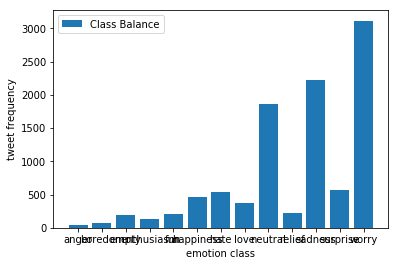

In [99]:
import matplotlib.pyplot as plt

plt.bar(emotions, class_dictionary.values(), label="Class Balance")

plt.legend()
plt.xlabel('emotion class')
plt.ylabel('tweet frequency')

plt.show()

## Uh Oh, very unbalanced data! May have to do:
* Upsampling
* Use AUC instead of accuracy
* Weighted resampling / Data normalization

## Text Preprocessing

In [52]:

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def spell_correct(words):
    """ Fix spelling corrections """
    corrected_words = []
    
    for word in words:
        corrected_words.append(TextBlob(word).correct().raw)

    return corrected_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = lemmatize_verbs(words)
    words = remove_stopwords(words)
    words = spell_correct(words)
    return words

# words = normalize(X_train)
data["content"] = data["content"].apply(lambda x: " ".join(normalize(x)))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [53]:
data.head()

,sentiment,content
0,empty,tiffanylue know listening bad habit earlier st...
1,sadness,laying n bed headache ughhhh waiting call
2,sadness,funeral ceremony gloomy friday
3,enthusiasm,want hang friends soon
4,neutral,dannycastillo want trade someone houston ticke...


## Train/Test Split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(data["content"], data['sentiment'], test_size=0.3, random_state=123)

## Naive Bayes w/ TFIDF
* We make the assumption that the features are conditionally independent given an output class. This assumption is most likely not true — hence the name naive Bayes classifier, but the classifier nonetheless performs well in most situations.

In [55]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


tf = TfidfVectorizer()
text_tf = tf.fit_transform(data['content'])

NB_X_train, NB_X_test, NB_y_train, NB_y_test = train_test_split(text_tf, data['sentiment'], test_size=0.3, random_state=123)

# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(NB_X_train, NB_y_train)
predicted= clf.predict(NB_X_test)

print("MultinomialNB Accuracy:",metrics.accuracy_score(NB_y_test, predicted))

MultinomialNB Accuracy: 0.30333333333333334


## Tokenize each tweet to be an array of words
* Double check if needed because we are already using Keras tokenizer... however, I think Keras Tokenizer is doing something differen ie: One Hot enoding based off of unique vocab.. not 100% though

In [56]:
X_train = data.apply(lambda row: word_tokenize(row['content']), axis=1)
# X_train

## Output Class - Label Encoding

In [57]:
from keras.utils.np_utils import to_categorical

label_encoder = preprocessing.LabelEncoder()
output_classes = label_encoder.fit(data['sentiment'])
output_classes = label_encoder.transform(data['sentiment'])
output_classes = to_categorical(output_classes)


In [58]:
label_encoder.classes_

array(['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness',
       'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise',
       'worry'], dtype=object)

In [59]:
len(label_encoder.classes_)

13

### Keras Tokenizer will convert the tweets to sequences so that they can be passed through embedding matrices.

In [60]:
# Change from two tokenizers to one. fit transofrm then just transform

tk = Tokenizer(filters='')

tk.fit_on_texts(X_train)
tk.texts_to_sequences(X_test)


train_tokenized = tk.texts_to_sequences(X_train)
test_tokenized = tk.texts_to_sequences(X_test)

max_len = 100

X_train = pad_sequences(train_tokenized, maxlen = max_len)
X_test = pad_sequences(test_tokenized, maxlen = max_len)

# labels = to_categorical(np.asarray(data['sentiment'].unique()))

## Serialization for Keras Tokenizer to be used in production

In [85]:
# https://pythonprogramming.net/python-pickle-module-save-objects-serialization/
import pickle

pickle_out = open("trained_tokenizer.pickle","wb")
pickle.dump(tk, pickle_out)
pickle_out.close()

**fit_on_texts** Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

**texts_to_sequences** Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.

## Loading Glove embeddings into dictionary

In [61]:
# embeddings_index = {}
# file = open('../data/glove.twitter.27B/glove.twitter.27B.100d.txt')
# for line in file:
#     values = line.split(' ')
#     word = values[0] # The first entry is the word
#     coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
#     embeddings_index[word] = coefs
# file.close()


glove_file = '../data/glove.twitter.27B/glove.twitter.27B.100d.txt'
emb_dict = {}
glove = open(glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

print('GloVe data loaded')

GloVe data loaded


In [62]:
from numpy import zeros

'''
Create a matrix of one embedding for each word in the training dataset. 
We can do that by enumerating all unique words in the Tokenizer.word_index 
and locating the embedding weight vector from the loaded GloVe embedding.
'''

vocab_size = len(tk.word_index) + 1

embedding_matrix = zeros((vocab_size, 100))
for word, i in tk.word_index.items():
    embedding_vector = emb_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [63]:
len(tk.word_index)

12072

In [64]:
len(output_classes)

10000

## Constants for Embedding Layers

In [71]:
NB_WORDS = 50000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = len(X_train)  # Size of the validation set
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 100  # Maximum number of words in a sequence
GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings


## Embedding Layer without Glove weights

In [72]:
emb_model = Sequential()
emb_model.add(Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(Flatten())
emb_model.add(Dense(13, activation='softmax'))
# emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
# compile the model
emb_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# summarize the model
print(emb_model.summary())
# fit the model
emb_model.fit(X_train, output_classes, epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 8)            400000    
_________________________________________________________________
flatten_6 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 13)                10413     
Total params: 410,413
Trainable params: 410,413
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
10000/10000 [==============================] - 2s 207us/step - loss: 1.9800 - acc: 0.3038
Epoch 2/100
10000/10000 [==============================] - 1s 113us/step - loss: 1.9183 - acc: 0.3233
Epoch 3/100
10000/10000 [==============================] - 1s 107us/step - loss: 1.8307 - acc: 0.3867
Epoch 4/100
10000/10000 [==============================] - 1s 109us/step - loss: 1.6916 -

10000/10000 [==============================] - 1s 110us/step - loss: 0.0309 - acc: 0.9918
Epoch 74/100
10000/10000 [==============================] - 1s 125us/step - loss: 0.0305 - acc: 0.9913
Epoch 75/100
10000/10000 [==============================] - 1s 121us/step - loss: 0.0298 - acc: 0.9916
Epoch 76/100
10000/10000 [==============================] - 1s 107us/step - loss: 0.0292 - acc: 0.9915
Epoch 77/100
10000/10000 [==============================] - 1s 99us/step - loss: 0.0284 - acc: 0.9911
Epoch 78/100
10000/10000 [==============================] - 1s 98us/step - loss: 0.0279 - acc: 0.9913
Epoch 79/100
10000/10000 [==============================] - 1s 101us/step - loss: 0.0274 - acc: 0.9915
Epoch 80/100
10000/10000 [==============================] - 1s 99us/step - loss: 0.0267 - acc: 0.9916
Epoch 81/100
10000/10000 [==============================] - 1s 102us/step - loss: 0.0260 - acc: 0.9922
Epoch 82/100
10000/10000 [==============================] - 1s 99us/step - loss: 0.0258 -

## With Glove Embedding Weights

In [73]:
emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [74]:
glove_model = Sequential()
glove_model.add(Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
glove_model.add(Flatten())
glove_model.add(Dense(13, activation='softmax'))
glove_model.summary()

glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False

glove_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          5000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 13)                130013    
Total params: 5,130,013
Trainable params: 5,130,013
Non-trainable params: 0
_________________________________________________________________


In [75]:
glove_model.fit(X_train, output_classes, epochs=50)

Epoch 1/50
10000/10000 [==============================] - 2s 160us/step - loss: 2.0016 - acc: 0.3042
Epoch 2/50
10000/10000 [==============================] - 1s 129us/step - loss: 1.7783 - acc: 0.3745 1s - loss
Epoch 3/50
10000/10000 [==============================] - 1s 112us/step - loss: 1.6684 - acc: 0.4114
Epoch 4/50
10000/10000 [==============================] - 1s 114us/step - loss: 1.5944 - acc: 0.4330
Epoch 5/50
10000/10000 [==============================] - 1s 115us/step - loss: 1.5394 - acc: 0.4477
Epoch 6/50
10000/10000 [==============================] - 1s 149us/step - loss: 1.4939 - acc: 0.4626
Epoch 7/50
10000/10000 [==============================] - 1s 128us/step - loss: 1.4557 - acc: 0.4764
Epoch 8/50
10000/10000 [==============================] - 1s 133us/step - loss: 1.4258 - acc: 0.4827
Epoch 9/50
10000/10000 [==============================] - 1s 120us/step - loss: 1.3964 - acc: 0.4946
Epoch 10/50
10000/10000 [==============================] - 1s 135us/step - loss: 

## Map indexes to classes for label decoding during prediction

In [79]:
output_class_dict = {}

for index in range(0, len(label_encoder.classes_)):
    output_class_dict[index] = label_encoder.classes_[index]
    
output_class_dict

{0: 'anger',
 1: 'boredom',
 2: 'empty',
 3: 'enthusiasm',
 4: 'fun',
 5: 'happiness',
 6: 'hate',
 7: 'love',
 8: 'neutral',
 9: 'relief',
 10: 'sadness',
 11: 'surprise',
 12: 'worry'}

In [80]:
y_pred = emb_model.predict(X_test) # Prediction on test data

results = []

# Iterate over probabilities of each emotion's classification
for sentiment in y_pred:
    max_val = np.where(sentiment == np.amax(sentiment))
#     print(max_val[0][0])
    results.append(output_class_dict[max_val[0][0]])

# results


In [81]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, results)

0.9943333333333333

In [84]:
emb_model.save("emotion_classification.h5")

# Below is experimenting with other NLP techniques, will come back to if current methods are overfit or not performing well enough. But for now ignore everything below!

## ELMO Embeddings


In [349]:
import tensorflow_hub as hub 
import tensorflow as tf 
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [350]:
X_train, X_test, y_train, y_test = train_test_split(data["content"], 
                                                  data['sentiment'],  
                                                  random_state=42, 
                                                  test_size=0.2)

In [351]:
def elmo_vectors(x):
  embeddings = elmo(x.tolist(), signature="default", as_dict=True)["elmo"]

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    # return average of ELMo features
    return sess.run(tf.reduce_mean(embeddings,1))

In [353]:
list_train = [X_train[i:i+100] for i in range(0,X_train.shape[0],100)]
list_test = [X_test[i:i+100] for i in range(0,X_test.shape[0],100)]

In [355]:
# Extract ELMo embeddings 
elmo_train = [elmo_vectors(x['content']) for x in list_train] 
elmo_test = [elmo_vectors(x['content']) for x in list_test]

KeyError: 'content'

In [ ]:
# save elmo_train_new
pickle_out = open("elmo_train_07012019.pickle","wb")
pickle.dump(elmo_train_new, pickle_out)
pickle_out.close()

# save elmo_test_new
pickle_out = open("elmo_test_07012019.pickle","wb")
pickle.dump(elmo_test_new, pickle_out)
pickle_out.close()

In [ ]:
# load elmo_train_new
pickle_in = open("elmo_train_03032019.pickle", "rb")
elmo_train_new = pickle.load(pickle_in)

# load elmo_train_new
pickle_in = open("elmo_test_03032019.pickle", "rb")
elmo_test_new = pickle.load(pickle_in)

In [ ]:
from sklearn.model_selection import train_test_split

xtrain, xvalid, ytrain, yvalid = train_test_split(elmo_train_new, 
                                                  data['content'],  
                                                  random_state=42, 
                                                  test_size=0.2)

## MLP for classification with ELMO Embeddings

In [ ]:
# Init model
model = Sequential()
# Embedding layer using Glove Pretrained weights
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=100, trainable=False))
# Flattening to conncet to Dense layer
model.add(Flatten())
model.add(Dense(1, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model
model.fit(X_train, output_classes, epochs=50, verbose=0)



# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import f1_score

# lreg = LogisticRegression()
# lreg.fit(xtrain, ytrain)

# What to get done by Thursday
* Feed Embedding layer to LSTM layer and stacked LSTM layer
* Evaluate and compare the different Embedding models w/ each other and do hyper-parameter tuning
* Visualize classification results
* Model Debugging

### Building RNN Model

If you wish to connect a Dense layer directly to an Embedding layer, you must first flatten the 2D output matrix to a 1D vector using the Flatten layer.

We chose the 100-dimensional version, therefore the Embedding layer must be defined with output_dim set to 100.

In [287]:
# Want to add Stacked LSTM

# Added Recurrent single LSTM layer, 
# model.add(LSTM(64, return_sequences=False,dropout=0.1, recurrent_dropout=0.1))
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten

# Init model
model = Sequential()
# Embedding layer using Glove Pretrained weights
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=100, trainable=False))
# Flattening to conncet to Dense layer
model.add(Flatten())
model.add(Dense(1, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model
model.fit(X_train, output_classes, epochs=50, verbose=0)
# evaluate the model
# loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 100, 100)          27100     
_________________________________________________________________
flatten_20 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 10001     
Total params: 37,101
Trainable params: 10,001
Non-trainable params: 27,100
_________________________________________________________________
None


InvalidArgumentError: Received a label value of 9 which is outside the valid range of [0, 1).  Label values: 7 6 6 6 9 7 7 9 9 2 7 9 5 6 9 7 8 9 7 3 7 9 7 9 0 9 6 2 4 1 0 6
	 [[{{node loss_15/dense_20_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}} = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT64, _class=["loc:@train...s_grad/mul"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](loss_15/dense_20_loss/Log, loss_15/dense_20_loss/Cast)]]

## Data Preprocessing Notes
* Need to remove mentions


 ### Medium Research Notes:

If we need to create a embedding mapping for words with training, how does this affect how we embed the test data (streamed tweets)? Maybe just use Glove.

Shall we use Embedding layer as our input layer?

Preprocessing
KD article
Padding
Remove stop words


CNN training is 1.5 times faster than training LSTMs

Need to determine the unique vocabulary of training in order to determine embedding vector length, then I think you pad off of that? Not sure about the padding preprocessing step.

Pathtoword embeddings is the path where we’ve  downloaded word embeddings via glove or number batch

Is it cheating if I understand all the processing of what this article is doing, and add my own preprocessing, and maybe additional steps? 
https://medium.com/@panghalarsh/sentiment-analysis-in-python-using-keras-glove-twitter-word-embeddings-and-deep-rnn-on-a-combined-580646cb900a

Word Embeddings is better than count vectorizers that one hot encodes sentences because the bagofwords model will not scale well to large datasets due to create sparse vectors in high dimensionality. Also we lose semantics through BagofWords approach. Word embeddings are dense vectors with much lower dimensionality. Secondly, the semantic relationships between words are reflected in the distance and direction of the vectors.

Should read into each Keras library being utilized and understanding 


Need to encode output classes (emotions) w/ LabelEncoders

Why do we need to Flatten after we do embedding? Like what does that do?

In the Embedding layer (which is layer 0 here) we set the weights for the words to those found in the GloVe word embeddings. By setting trainable to False we make sure that the GloVe word embeddings cannot be changed.

The best result is achieved with 100-dimensional word embeddings that are trained on the available data. By doing this, we do not take into account the relationships between the words in the tweet. This can be achieved with a recurrent neural network or a 1D convolutional network. But that’s something for a future post.
— Bert Carremans 


Do we need padding when utilizing word embeddings? I saw some Word2Vec tutorials using padding one hot encoded sequences, but my understanding was that we don’t need it for embeddings.
https://medium.com/datadriveninvestor/sentiment-analysis-using-embeddings-f3dd99aeaade


Why train my own word embeddings at all? Why not always use Glove? It seems to be a better trained for my model’s embedding layer anyways.


There are so many state of the art embedding techniques like SkipGrams, FastText, and ELMo. I should investigate these for their result to text summarizations.


In [14]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
import numpy as np

# check this out:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
model = Sequential()
model.add(Embedding(7, 3, input_length=5))
# model.add(Flatten())
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be
# no larger than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch dimension.

input_array = np.array([[0, 1, 2, 3, 4], [5, 1, 2, 3, 6]])
print(input_array)
# model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array)

[[0 1 2 3 4]
 [5 1 2 3 6]]
[[[ 0.01658997 -0.03503971 -0.03524492]
  [ 0.02105062 -0.02567688 -0.02039844]
  [-0.02736325 -0.00165455  0.00108389]
  [-0.01605218  0.04671435 -0.04131665]
  [ 0.02627129 -0.02832104  0.01373578]]

 [[-0.03747336 -0.02579566  0.03765706]
  [ 0.02105062 -0.02567688 -0.02039844]
  [-0.02736325 -0.00165455  0.00108389]
  [-0.01605218  0.04671435 -0.04131665]
  [-0.04258297  0.01286627  0.01142017]]]


## Using ELMo's pretrained model
* When we import this model, should keep it trainable?